# Outline.

1. Loading of the data
2. Preparation of the data and the algorithm
3. Realization of the error-based complementary filter
4. Demonstration of the results
5. Optimization of the error-based complementary filter
6. Realization of the minimization-based passive complementary filter
7. Demonstration of the results of the minimization-based passive filter

# 1. Loading of the data

In [2]:
#Import of all necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import pylab
import scipy.optimize

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\All\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
#Loading of the data file

data = np.load('DonnesBrutesCapteurs_Sysnav2014.npy', allow_pickle=True).flat[0]

Mag = data['Mag'] # Magnetic field expressed in G
Time = data['Time'] # Elapsed time expressed in s
Gamma = data['Gamma'] # Accelerometers measurements expressed in m*s^-2
Omega = data['Omega'] # Gyrometers measurements of angular velocity expressed in rad*s^-1

#Time increment (it is constant throughout all the measurements series)
T = Time[1] - Time[0]

#Number of experimental points
N = Time.shape[0]

# 2. Preparation of the data and the algorithm

In [4]:
# Normalization of the vectors of the acceleration and magnetic field 

for i in range(N):
    Gamma[i] = Gamma[i] / np.linalg.norm(Gamma[i])
    Mag[i] = Mag[i] / np.linalg.norm(Mag[i])

# Gravity vector in the inertial frame 
a0 = Gamma[0]

# Earth magnetic field in the inertial frame (at the initial time instant the inertial frame should be the same as 
# the body frame, therefore the m0 vector can be expressed as the magnetometer read-outs at t=0)

m0 = Mag[0]

In [5]:
# This function converges a 3-vector to a 3*3 skew-symmetric matrix
def vec_to_so3(vec):
    X = np.zeros([3,3])
    X[0,1] = - vec[2]
    X[0,2] = vec[1]
    X[1,0] = vec[2]
    X[1,2] = - vec[0]
    X[2,0] = - vec[1]
    X[2,1] = vec[0]
    
    return X

In [6]:
# This function calculates a matrix exponential of an orthogonal matrix using the Rodrigue's formula.
# R must be a 3*3 matrix, T is time increment
def rodrigues(R,T=T):
    norm = np.linalg.norm(R * T)
    return np.identity(3) + R * np.sin(norm) / norm + np.dot(R, R) / (norm ** 2) * (1 - np.cos(norm))

In [7]:
#Tunable parameters of the algorithm (taken from the paper of Hamel and Mahony)
k_I = 0.3 # inertial gain expressed in rad*s^-2. The reasoning of the choice is given in the section 5.
k_P = 3.0 # proportional gain expressed in rad*s^-1. The reasoning of the choice is given in the section 5.

k_A = 0.8 # relative confidence for accelerometers. 
k_M = 0.2 # relative confidence for magnetometers. 

# 3. Realization of the error-based complementary filter

In [8]:
# A list for storage of R^ orthogonal matrices 
R_lst = [] 

# A list for storage of Omega_y matrices, where Omega_y are data from gyrometers
# expressed as a skew-symmetric 3*3 matrix
Omega_lst = [] 

# A list for storage of w vectors, where w is a correction angular velocity
w_lst = [] 

# A list for storage of bias vectors
b_lst = []

# A list for storage of values of the cost function
E_lst = []

$\omega_{k, acc} = k_A \left(a_k \times \hat{R_k}^T a_0 \right)$, where $a_k$ are data from the accelerometers,
$a_0$ is the gravity vector in the inertial frame

$\omega_{k, mag} = k_M \left(m_k \times \hat{R_k}^T m_0 \right)$, where $m_k$ are data from the magnetometers,
$m_0$ is the vector of the Earth magnetic field in the inertial frame

The correction term $\omega_k$ can be expressed as follows:
$\omega_k = - k_P(\omega_{k, acc} + \omega_{k, mag})$

$ 0 \le k \le N - 1 $

The cost function at k-th time instant can be calculated in the following way:
    
$ E_{cost, k} = k_A(1 - < \hat{R_k}^T a_0 , a_0 >) + k_M(1 - < \hat{R_k}^T m_0 , m_0 >) $

The initial approximation for the bias vector and the $\hat{R_0}^T$ is a $[0, 0, 0]^T$ vector and 3*3 identity matrix, respectively. 

In [9]:
# This part of the code is for filling of all lists with the initial conditions
# and calculations at the initial time instant

R0 = np.identity(3) #initial approximation of the R^
b0 = np.array([-0.05821462,  0.00540516,  0.0663445 ]) #initial approximation of bias vector
# The components of the initial bias vector have been obtained by optimization given in the section 5 
b_lst.append(b0)
R_lst.append(R0)
Omega_lst.append(vec_to_so3(Omega[0]))

#calculation of w_0
w_0_acc = k_A * np.cross(Gamma[0], np.dot(R_lst[0].T, - a0))
w_0_mag = k_M * np.cross(Mag[0], np.dot(R_lst[0].T, - m0))
w_lst.append(- k_P * (w_0_acc + w_0_mag))

#calculation of the cost function 
acc_part = np.vdot(np.dot(R_lst[0].T, a0), Gamma[0])
mag_part = np.vdot(np.dot(R_lst[0].T, m0), Mag[0])
E_lst.append(k_A * (1 - acc_part) + k_M * (1 - mag_part))

The following part of the code is for calculation of correction terms $\omega_k$, rotation matrices $\hat{R_k}^T$, bias vectors $b_k$ and cost function $E_{cost, k}$ at k-th time instant using the calculation of these values at (k-1)-th time instant. 

The expressions for calculation of $\omega_k$ and $E_{cost, k}$ have been described just above. 

The corrected angular velocity:

$(\Omega_k)_{\times} = (\Omega_{k, y} - b_k + \omega_k)_{\times}$

The rotational matrix $\hat{R_{k+1}}^T$ at the (k+1)-th time instant can be found according to the Rodrigue's formula of matrix exponential of an orthogonal matrix:

$\hat{R_{k+1}}^T = \hat{R_{k}}^T exp(T(\Omega_k)_x)$

In [10]:
for k in range(1, N, 1):
    
    #calculation of w_k
    w_k_acc = k_A * np.cross(Gamma[k], np.dot(R_lst[k - 1].T, - a0))
    w_k_mag = k_M * np.cross(Mag[k], np.dot(R_lst[k - 1].T, - m0))
    w_k = - k_P * (w_k_acc + w_k_mag)
    w_lst.append(w_k)
    
    #calculation of bias_k
    b_k = b_lst[k - 1] - T * k_I / k_P * w_lst[k - 1]
    b_lst.append(b_k)
    
    #calculation of Omega_k 
    Omega_k = vec_to_so3(Omega[k - 1]) - vec_to_so3(b_lst[k - 1]) + vec_to_so3(w_lst[k - 1])
    Omega_lst.append(Omega_k)
    
    #calculation of R^_k orthogonal matrices
    R_k = np.dot(R_lst[k - 1], rodrigues(Omega_lst[k - 1] * T ))
    R_lst.append(R_k)
    
    #calculation of the cost function 
    acc_part = np.vdot(np.dot(R_lst[k - 1].T, a0), Gamma[k])
    mag_part = np.vdot(np.dot(R_lst[k - 1].T, m0), Mag[k])
    E_lst.append(k_A * (1 - acc_part) + k_M * (1 - mag_part))

# 4. Demonstration of the results

In [11]:
# Integration of raw-data angular velocity (without application of the filter)

Angles = np.zeros([3, N])

for i in range(1, N, 1):
    Angles[:, i] = Angles[:, i - 1] + Omega.T[:, i - 1] * T

In [12]:
# Integration of corrected angular velocity (with application of the filter)

Angles_corr = np.zeros([3, N])

for i in range(1, N, 1):
    Angles_corr[:, i] = Angles_corr[:, i - 1] + (Omega[i - 1] - b_lst[i - 1] + w_lst[i - 1]) * T

1) Results for the x-axis angle (roll angle)

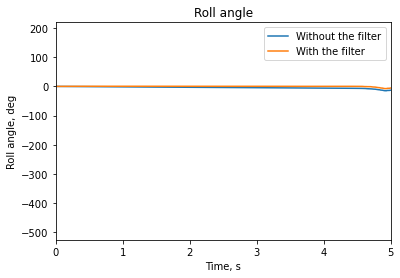

In [13]:
plt.title('Roll angle')
plt.xlabel('Time, s')
plt.ylabel('Roll angle, deg')
plt.plot(Time, Angles[0] * (180 / np.pi), label='Without the filter')
plt.plot(Time, Angles_corr[0] * (180 / np.pi), label='With the filter')
pylab.xlim(0, 5)
plt.legend()

2) Results for the y-axis angle (pitch angle)

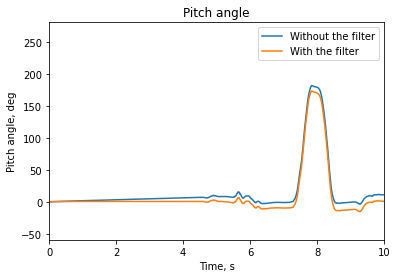

In [14]:
plt.title('Pitch angle')
plt.xlabel('Time, s')
plt.ylabel('Pitch angle, deg')
plt.plot(Time, Angles[1] * (180 / np.pi), label='Without the filter')
plt.plot(Time, Angles_corr[1] * (180 / np.pi), label='With the filter')
pylab.xlim(0,10)
plt.legend()

3) Results for the z-axis angle (yaw angle)

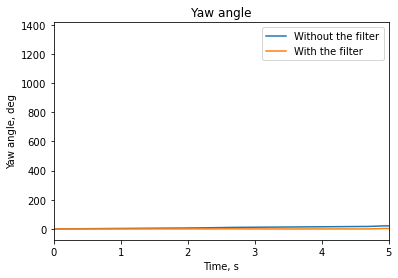

In [16]:
plt.title('Yaw angle')
plt.xlabel('Time, s')
plt.ylabel('Yaw angle, deg')
plt.plot(Time, Angles[2] * (180 / np.pi), label='Without the filter')
plt.plot(Time, Angles_corr[2] * (180 / np.pi), label='With the filter')
plt.xlim(0,5)
plt.legend()

4) Estimation for bias of gyrometers

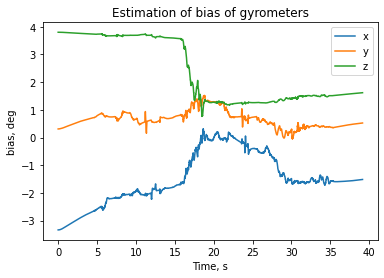

In [107]:
plt.title('Estimation of bias of gyrometers')
plt.xlabel('Time, s')
plt.ylabel('bias, deg')
plt.plot(Time, np.array(b_lst)[:, 0] * (180 / np.pi), label='x')
plt.plot(Time, np.array(b_lst)[:, 1] * (180 / np.pi), label='y')
plt.plot(Time, np.array(b_lst)[:, 2] * (180 / np.pi), label='z')
plt.legend()

5) Estimation of the cost function

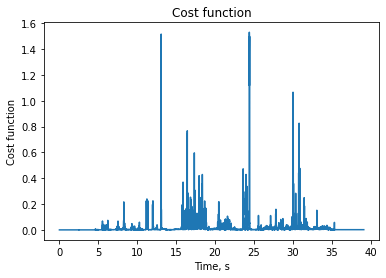

In [108]:
plt.title('Cost function')
plt.xlabel('Time, s')
plt.ylabel('Cost function')
plt.plot(Time, E_lst)

# 5. Optimization of the error-based complementary filter

1) Optimization of the initial bias vector

In [17]:
# The less is the sum of the values of the cost function, the better is the algorithm
# Here, x is the list with three elements
def cost_function(x): 
    R_lst = [] 
    Omega_lst = [] 
    w_lst = [] 
    b_lst = []
    E_lst = []

    R0 = np.identity(3) #initial approximation of the R^
    b0 = np.array(x) #initial approximation of bias vector
    b_lst.append(b0)
    R_lst.append(R0)
    Omega_lst.append(vec_to_so3(Omega[0]))

    #calculation of w_0
    w_0_acc = k_A * np.cross(Gamma[0], np.dot(R_lst[0].T, - a0))
    w_0_mag = k_M * np.cross(Mag[0], np.dot(R_lst[0].T, - m0))
    w_lst.append(- k_P * (w_0_acc + w_0_mag))

    #calculation of the cost function 
    acc_part = np.vdot(np.dot(R_lst[0].T, a0), Gamma[0])
    mag_part = np.vdot(np.dot(R_lst[0].T, m0), Mag[0])
    E_lst.append(k_A * (1 - acc_part) + k_M * (1 - mag_part))
    
    for k in range(1, N, 1):
    
        #calculation of w_k
        w_k_acc = k_A * np.cross(Gamma[k], np.dot(R_lst[k - 1].T, - a0))
        w_k_mag = k_M * np.cross(Mag[k], np.dot(R_lst[k - 1].T, - m0))
        w_k = - k_P * (w_k_acc + w_k_mag)
        w_lst.append(w_k)
    
        #calculation of bias_k
        b_k = b_lst[k - 1] - T * k_I / k_P * w_lst[k - 1]
        b_lst.append(b_k)
    
        #calculation of Omega_k 
        Omega_k = vec_to_so3(Omega[k - 1]) - vec_to_so3(b_lst[k - 1]) + vec_to_so3(w_lst[k - 1])
        Omega_lst.append(Omega_k)
    
        #calculation of R^_k orthogonal matrices
        R_k = np.dot(R_lst[k - 1], rodrigues(Omega_lst[k - 1] * T ))
        R_lst.append(R_k)
    
        #calculation of the cost function 
        acc_part = np.vdot(np.dot(R_lst[k - 1].T, a0), Gamma[k])
        mag_part = np.vdot(np.dot(R_lst[k - 1].T, m0), Mag[k])
        E_lst.append(k_A * (1 - acc_part) + k_M * (1 - mag_part))
        
    return sum(E_lst)

In [18]:
# The optimal components of the bias vector are being searched within the following bounds
bounds = [(-1, 1), (-1, 1), (-1, 1)]

In [19]:
scipy.optimize.minimize(cost_function, x0=[0, 0, 0], bounds=bounds, method='Nelder-Mead', options={'maxiter': 200})

C:\Users\All\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


 final_simplex: (array([[-0.05821462,  0.00540516,  0.0663445 ],
       [-0.05821357,  0.00541941,  0.06636341],
       [-0.05827233,  0.00544912,  0.06634926],
       [-0.05822192,  0.00535554,  0.06634569]]), array([334.23417307, 334.2341793 , 334.23417944, 334.23418996]))
           fun: 334.2341730691021
       message: 'Optimization terminated successfully.'
          nfev: 210
           nit: 114
        status: 0
       success: True
             x: array([-0.05821462,  0.00540516,  0.0663445 ])

In [83]:
#Result of the optimization process
b0_optimal = np.array([-0.05821462,  0.00540516,  0.0663445 ])

2) Optimization of the confidence $k_I$ and $k_P$ parameters.

In [94]:
bounds = [(0.0, 100.0), (0.0, 100.0)]

In [97]:
scipy.optimize.minimize(cost_function, x0=np.array([1.0   , 0.3]), bounds=bounds, method='Nelder-Mead', options={'maxiter':20})

 final_simplex: (array([[0.33299561, 2.96714337],
       [0.40704346, 3.52142596],
       [0.30681152, 1.93097717]]), array([322.73008932, 323.06009558, 323.17405734]))
           fun: 322.73008931546957
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([0.33299561, 2.96714337])

The method did not converge until the end on 20 iterations, but the optimal $k_I$ and $k_P$ can be considered as 0.3 and 3.0, respectively.

# 6. Realization of the minimization-based passive complementary filter

A minimization-based passive complementary filter uses a serie of rotation matrices R$_y$ as input parameter. The matrices can be found from the readouts of accelerometers and magnetometers according to the following expression:

$R_y = argmin_{R \in SO(3)} k_A||a_0 - Ra||^2 + k_M||m_0 - Rm||^2$,

where $a_0$ and $m_0$ are gravity and Earth magnetic field vectors in the inertial frame, a and m are readouts of the measurement units. The solution to this problem, known as the Wahba's problem can be found via the Singular Value Decomposition of the matrix $B = k_Aa_0a^T + k_Mm_0m^T$. If $B = USV^T$, the optimal matrix R can be found as

$R = U * diag([1;~1;~det(U)det(V)]) * V^T$

In [54]:
#This function takes readouts from accelerometer and magnetometer and returns Ry
def wahba(a, m, k_A = 0.8, k_M = 0.2):
    B = k_A * np.dot(a0.reshape(3, 1), a.reshape(1, 3)) + k_M * np.dot(m0.reshape(3, 1), m.reshape(1,3))
    SVD = np.linalg.svd(B)
    M = np.diag([1, 1, np.linalg.det(SVD[0]) * np.linalg.det(SVD[2])])
    R = np.dot(SVD[0], M, SVD[2])
    return R

In [55]:
#function returning an asymmetric projection of a matrix R
def proj_ass(R):
    return(0.5 * (R - R.T))

#this function takes a skew-symmetric matrix and returns a vector
def vex(A):
    return np.array([A[2, 1], A[0, 2], A[1, 0]])

In [111]:
#Initialization of the algorithm
R_y_lst = []

R_hat_lst = []

Omega_lst = []

A_lst = []

E_cost_passive = []

k = 0.1

In [112]:
R_y_lst.append(wahba(Gamma[0], Mag[0]))

R_hat_0 = np.identity(3) #initial approximation of R^0
R_hat_lst.append(R_hat_0)

Omega_lst.append(Omega[0])
E_cost_passive.append(0)

In [113]:
for i in range(1, N, 1):
    #calculation of Ry
    R_y_lst.append(wahba(Gamma[i], Mag[i]))
    
    #Calculation of R~ = R^T * Ry
    R_tilda = np.dot(R_hat_lst[i - 1].T, R_y_lst[i - 1])
    
    #Calculation of the cost function E_cost = || R~ - I_3 ||^2
    cost = 0.5 * np.trace(np.identity(3) - R_tilda)
    E_cost_passive.append(cost)
    
    #asymmteric projection of R~ and k multiplication
    # omega = k * proj_ass(R~) is a skew-symmetric 3*3 matrix
    pi_a_R_tilda = k * proj_ass(R_tilda)
    
    #calculation of Omega
    Omega_y = vec_to_so3(Omega[i - 1])
    
    
    #integration, here A = (Omega + k * omega)
    A = Omega_y + pi_a_R_tilda
    A_lst.append(A)
    R_hat_new = np.dot(R_hat_lst[i - 1], rodrigues(A * T))
    R_hat_lst.append(R_hat_new)

# 7. Demonstration of the results of the minimization-based passive filter

In [114]:
#Calculation of angles
Angles_passive = np.zeros([3, N])

for i in range(1, N, 1):
    Angles_passive[:, i] = Angles_passive[:, i - 1] + (vex(A_lst[i - 1])) * T

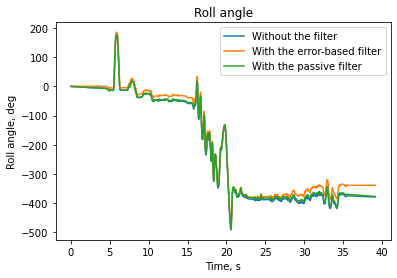

In [115]:
plt.title('Roll angle')
plt.xlabel('Time, s')
plt.ylabel('Roll angle, deg')
plt.plot(Time, Angles[0] * (180 / np.pi), label='Without the filter')
plt.plot(Time, Angles_corr[0] * (180 / np.pi), label='With the error-based filter')
plt.plot(Time, Angles_passive[0] * (180 / np.pi), label='With the passive filter')
plt.legend()

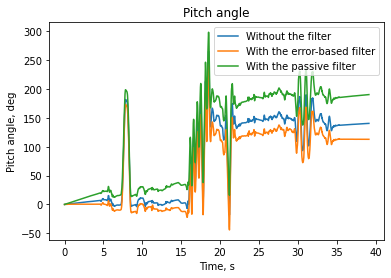

In [116]:
plt.title('Pitch angle')
plt.xlabel('Time, s')
plt.ylabel('Pitch angle, deg')
plt.plot(Time, Angles[1] * (180 / np.pi), label='Without the filter')
plt.plot(Time, Angles_corr[1] * (180 / np.pi), label='With the error-based filter')
plt.plot(Time, Angles_passive[1] * (180 / np.pi), label='With the passive filter')
plt.legend()

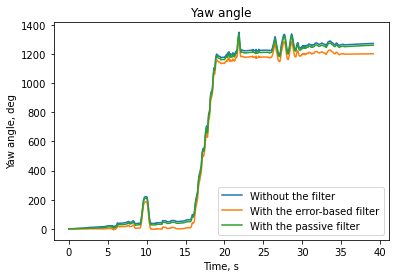

In [117]:
plt.title('Yaw angle')
plt.xlabel('Time, s')
plt.ylabel('Yaw angle, deg')
plt.plot(Time, Angles[2] * (180 / np.pi), label='Without the filter')
plt.plot(Time, Angles_corr[2] * (180 / np.pi), label='With the error-based filter')
plt.plot(Time, Angles_passive[2] * (180 / np.pi), label='With the passive filter')
plt.legend()

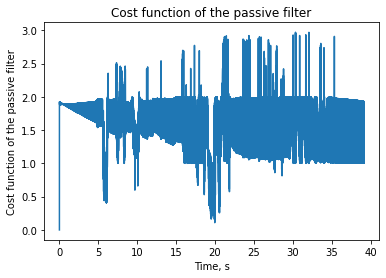

In [118]:
plt.title('Cost function of the passive filter')
plt.xlabel('Time, s')
plt.ylabel('Cost function of the passive filter')
plt.plot(Time, E_cost_passive)